____________________________
## Importing the Libraries
______________________________

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#pip install pydotplus

In [1]:
import os
import pandas as pd
import numpy as np
#from __future__ import print_function
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import os
import glob
from skimage import io
import skimage.transform as trans
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
#from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping,TensorBoard,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pydotplus
import time
start =time.process_time()
import cv2

________________________________________________
### Defining a function to load the data
________________________________________________

In [2]:
def dataset(file_directory1, file_directory2,features ,labels ,file_directory3= None,predictions = None):
    featured = []
    labelled = []
    prediction = []
    for feature in features:
        file1 = os.path.join(file_directory1, feature)
        for path in os.listdir(file1):
            img1 = os.path.join(file1, path)   
            images = cv2.imread(img1)
            images = cv2.resize(images, (512,512))
            featured.append(images)
    for label in labels:
        file2 = os.path.join(file_directory2, label)
        for path in os.listdir(file2):
            img2 = os.path.join(file2, path)
            images = cv2.imread(img2)
            images = cv2.resize(images, (512,512))
            images = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
            labelled.append(images)
    if file_directory3:
        for predict in predictions:
            file3 = os.path.join(file_directory3, predict)
            for path in os.listdir(file3):
                img3 = os.path.join(file3, path)   
                images = cv2.imread(img3)
                images = cv2.resize(images, (512,512))
                prediction.append(images)
        print("Done1!!!")        
        return featured, labelled, prediction
    else:
        print("Done2!!!")
        return featured, labelled
    

___________________________________________
### File Directories
___________________________________________

In [3]:
features = ["Training_images"]
labels = ["Training_label"]
file_dir1 = '/content/drive/MyDrive/Solar_Filament_detection/[Keji]/NewDatasetSolarDetection/Training_img'
file_dir2 = '/content/drive/MyDrive/Solar_Filament_detection/[Keji]/NewDatasetSolarDetection/Training_mask'

## Data Loading

In [5]:
images, masks  = dataset(file_dir1, file_dir2,features,labels)

Done2!!!


In [6]:
images = np.array(images)
masks = np.array(masks)
print("The shape of the Hydrogen-alpha file is: ", images.shape[1:])
print("The shape of the Mask file is: ", masks.shape[1:])

The shape of the Hydrogen-alpha file is:  (512, 512, 3)
The shape of the Mask file is:  (512, 512)


_______________________________________________________________
### Displaying solar filament images and their corresponding Masks
_______________________________________________________________

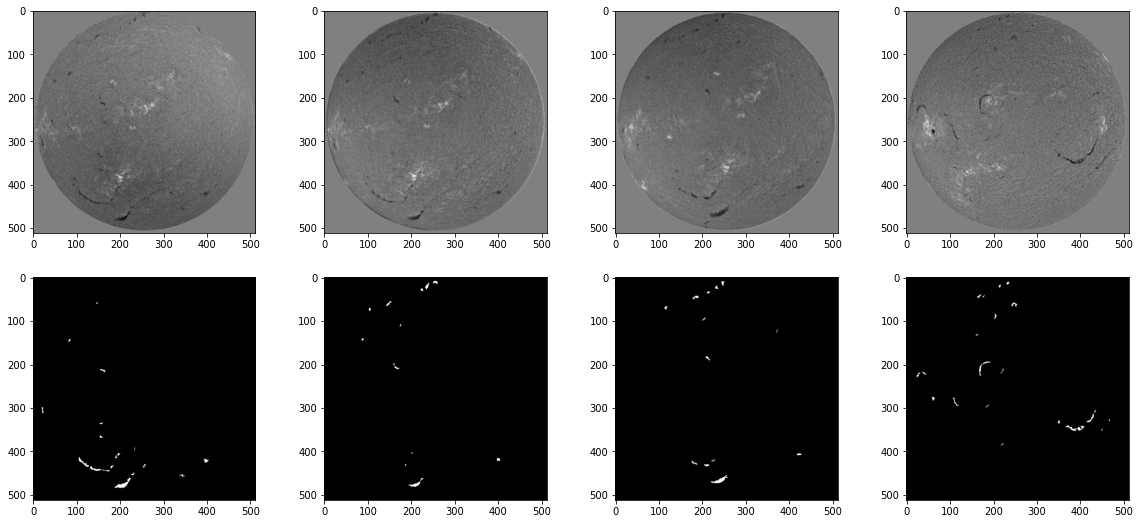

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(images[0])
plt.subplot(2,4,2)
plt.imshow(images[1])
plt.subplot(2,4,3)
plt.imshow(images[2])
plt.subplot(2,4,4)
plt.imshow(images[3])
plt.subplot(2,4,5)
plt.imshow(masks[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(masks[1], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(masks[2], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(masks[3], cmap = plt.cm.binary_r)
plt.show()

____________________________________________________________
##### Splitting the dataset into training set and test set 
_____________________________________________________________

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, masks , test_size = 0.25, random_state = 101)

______________________________________
### pixelwise labelling of images
______________________________________

__________________________________
### Training dataset Generator
___________________________________

In [9]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = 'data/filament/train/test/',target_size = (512,512),seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

### Validation Dataset Generator

In [10]:

def validationGenerator(batch_size,valid_path,image_folder,mask_folder,image_color_mode = "grayscale",mask_color_mode = "grayscale",flag_multi_class = False,num_class = 2,target_size = (512,512),seed = 1,save_to_dir= 'data/filament/train/test/'):
    validimg_datagen = ImageDataGenerator(rescale=1. / 255)
    validmask_datagen= ImageDataGenerator(rescale=1. / 255)
    validimg_generator= validimg_datagen.flow_from_directory(
        valid_path,
        classes = [image_folder],
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir = save_to_dir,
        class_mode=None,
        shuffle=True,
        seed=seed)

    validmask_generator= validmask_datagen.flow_from_directory(
        valid_path,
        classes = [mask_folder],
        color_mode=mask_color_mode,
        target_size=target_size,
        save_to_dir = save_to_dir,
        batch_size=batch_size,
        class_mode=None,
        shuffle=True,
        seed=seed)

    valid_generator = zip(validimg_generator, validmask_generator)
    for (img1,mask1) in valid_generator:
        img1,mask1 = adjustData(img1,mask1,flag_multi_class,num_class)
        yield (img1,mask1)

___________________________________________
### Testing Dataset Generator
___________________________________________

___________________________
### Dataset Augmentation
____________________________

In [5]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

___________________________________
### Pixelwise label Visualization
__________________________________

____________________________
### Function to Save Predicted Predicted Masks
____________________________

In [7]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
     for i,item in enumerate(npyfile): 
            img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            io.imsave(os.path.join(save_path,"%d_predicted_image.png"%i),img)

![unet](https://www.researchgate.net/profile/Jionglong-Su/publication/354384379/figure/fig2/AS:1127566148673560@1645844127915/Architecture-of-U-Net-30.png)

### U-NET MODEL ARCHITECTURE

In [10]:
model2 = filament_unet()
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

___________________________________
### Defining Evaluation Metrics
__________________________________

### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient, is a statistic for determining how similar and diverse sample sets are. The Jaccard coefficient, which is defined as the size of the intersection divided by the size of the union of the sample sets, is a measure of similarity between finite sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

In [17]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

### Dice coefficient
The Dice score is comparable to accuracy in that it not only measures how many positives you find, but it also penalizes you for false positives. As a result, it more simillar to precision rather than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [18]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Precision    
The costs of False Positive can be determine using precision.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [19]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

### Accuracy
Calculates the average accuracy rate for all binary classification predictions.

In [20]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

### Recall  
By identifying it as Positive, Recall estimates how many of the Actual Positives our model captures (True Positive). With the same reasoning, we know that when False Negative has a large cost, Recall will be the model metric we use to choose our best model.

![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [21]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

### Training and Validation Dataset Variable

In [22]:
myGene = trainGenerator(1,'/content/drive/MyDrive/Solar_Filament_detection/new_dataset/Training_img','Training_images','Training_label',data_gen_args,save_to_dir = None)
myVal = validationGenerator(1,'/content/drive/MyDrive/Solar_Filament_detection/new_dataset','Validation_Image','Validation_label',save_to_dir = None)

### Model Compilation

In [31]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

model2.compile(optimizer =  Adam(learning_rate = 1e-3,beta_1=0.9, beta_2=0.999), loss ='binary_crossentropy', metrics=[iou, precision, recall, accuracy])
loss_history = []

## Model Training

In [25]:
learning_rate_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.7, patience=3, verbose=1, min_delta=1e-4, mode='min')
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Solar_Filament_detection/dataset/new_dataset/filament_unet.hdf5', monitor='loss',verbose=1, save_best_only=True,save_weights_only=True)
model_EarlyStopping = EarlyStopping(monitor='loss', min_delta=0.0001, patience=7, verbose=0, mode='auto')
loss_history += [model2.fit(myGene, steps_per_epoch=400, epochs = 50, validation_data =myVal,validation_steps = 400,shuffle=True,
                                         callbacks=[model_checkpoint, learning_rate_reduce,model_EarlyStopping])]
end=time.process_time()
print('Running time: %s Seconds'%(end-start))

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 15.0993 - iou: 0.9999 - precision: 0.4865 - recall: 0.1446 - accuracy: 0.9879Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.

Epoch 1: loss improved from inf to 15.09926, saving model to /content/drive/MyDrive/Solar_Filament_detection/dataset/new_dataset/filament_unet.hdf5
400/400 [==============================] - 200s 447ms/step - loss: 15.0993 - iou: 0.9999 - precision: 0.4865 - recall: 0.1446 - accuracy: 0.9879 - val_loss: 0.0144 - val_iou: 1.0000 - val_precision: 0.5051 - val_recall: 0.4091 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.0387 - iou: 0.9999 - precision: 0.8400 - recall: 0.5285 - accuracy: 0.9901
Epoch 2: loss improved from 15.09926 to 0.03872, saving model to /content/drive/MyDrive/Solar_Filament_detection/dataset/new_dataset/f

In [13]:
testGene = testGenerator('new_dataset/Testing/Testing_image')
model = filament_unet()
model.load_weights("filament_unet.hdf5")
results = model.predict(testGene,10,verbose=0)
saveResult("new_dataset/Testing/unet_Predicted_label",results)

bbso_halph_fi_20130531_151102_unetimg.jpg
bbso_halph_fi_20130611_181553_nimg.jpg
bbso_halph_fi_20130614_212450_unetimg.jpg
bbso_halph_fi_20130618_230104_nimg.jpg
bbso_halph_fi_20130619_222440_nimg.jpg
bbso_halph_fi_20130620_225926_nimg.jpg
bbso_halph_fi_20130621_230824_nimg.jpg
bbso_halph_fi_20130625_191307_nimg.jpg
bbso_halph_fi_20130626_195438_nimg.jpg
bbso_halph_fi_20130627_152035_unetimg.jpg


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

In [14]:
features = ["Testing_image"]
labels = ["Testing_label"]
predictions = ["unet_Predicted_label"]
#file_dir1 = "/content/drive/MyDrive/Solar_Filament/[Keji]/new_dataset/Testing"
#file_dir2 = "/content/drive/MyDrive/Solar_Filament/[Keji]/new_dataset/Testing"
#file_dir3 = "/content/drive/MyDrive/Solar_Filament/[Keji]/new_dataset/Testing"

file_dir1 = "new_dataset/Testing"
file_dir2 = "new_dataset/Testing"
file_dir3 = "new_dataset/Testing"

In [98]:
images, masks, predicted_mask  = dataset(file_dir1, file_dir2,features,labels,file_dir3,predictions)

Done1!!!


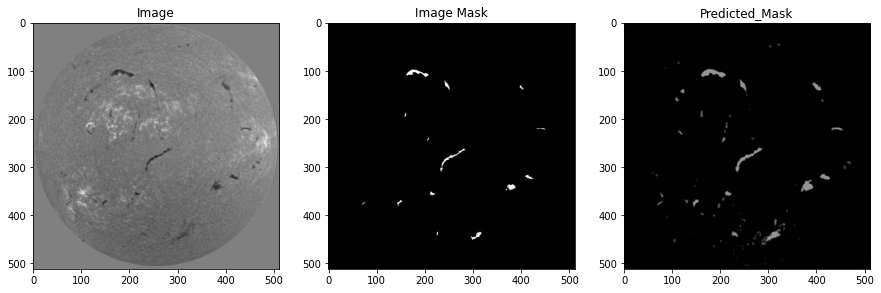

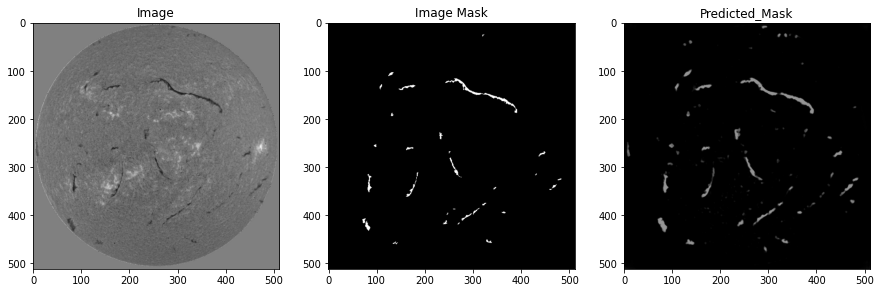

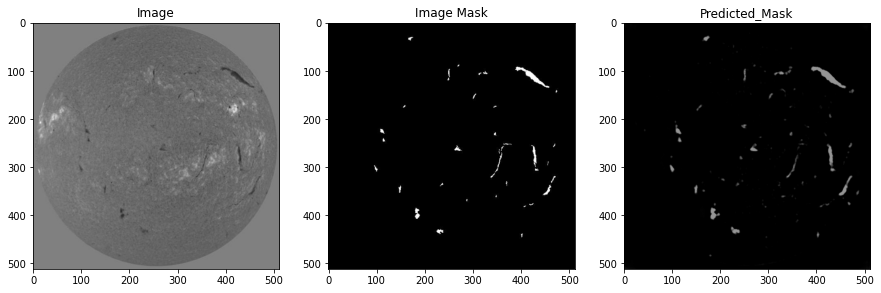

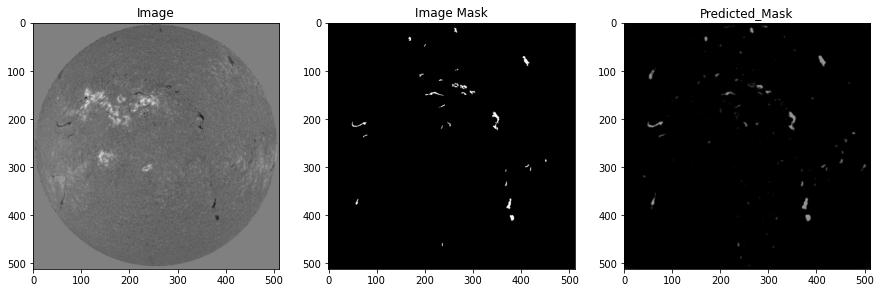

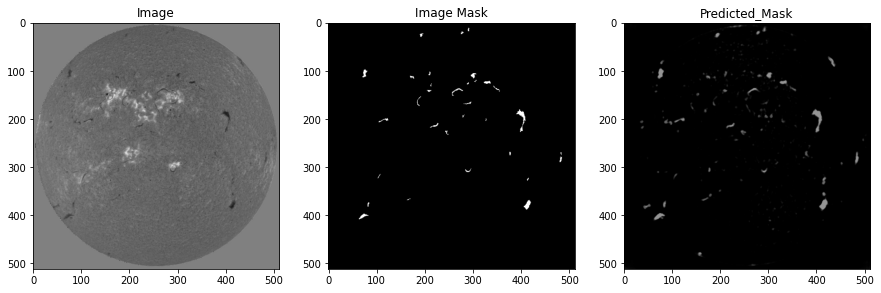

In [103]:
#from skimage import data, io, filters
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
for i in range(5):
    image  = (images[i])
    pred_mask = predicted_mask[i]
    mask = masks[i]

    fig = plt.figure(figsize=(15,15))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(image)
    ax.set_title("Image")
    
    ax = fig.add_subplot(1,3,2)
    plt.imshow(masks[i], cmap = plt.cm.binary_r)
    ax.set_title("Image Mask")
   
    ax = fig.add_subplot(1,3,3)
    pred_mask = scipy.ndimage.median_filter(pred_mask, size=3)
    ax.imshow(pred_mask)
    ax.set_title("Predicted_Mask")
    plt.show()



In [77]:
from skimage.io import imread
from sklearn.metrics import roc_curve, auc

In [94]:
fpr1, tpr1,threshold1= roc_curve(ground_truth_labels1,mask1_1)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, threshold2 = roc_curve(ground_truth_labels2,mask2_2)
roc_auc2 = auc(fpr2,tpr2)
fpr3, tpr3, threshold3 = roc_curve(ground_truth_labels3,mask3_3)
roc_auc3 = auc(fpr3,tpr3)
fpr4, tpr4, threshold4 = roc_curve(ground_truth_labels4,mask4_4)
roc_auc4 = auc(fpr4,tpr4)
fpr5, tpr5,threshold5 = roc_curve(ground_truth_labels5,mask5_5)
roc_auc5 = auc(fpr5,tpr5)
fpr6, tpr6, threshold6 = roc_curve(ground_truth_labels6,mask6_6)
roc_auc6 = auc(fpr6,tpr6)
fpr7, tpr7, threshold7 = roc_curve(ground_truth_labels7,mask7_7)
roc_auc7 = auc(fpr7,tpr7)
fpr8, tpr8, threshold8 = roc_curve(ground_truth_labels8,mask8_8)
roc_auc8 = auc(fpr8,tpr8)
fpr9, tpr9, threshold9 = roc_curve(ground_truth_labels9,mask9_9)
roc_auc9 = auc(fpr9,tpr9)
fpr10, tpr10, threshold10 = roc_curve(ground_truth_labels10,mask10_10)
roc_auc10 = auc(fpr10,tpr10)

In [72]:
performance_metric = []
performance_metric.append(DSC)
performance_metric.append(tpr_metric)
performance_metric.append(fpr_metric)
performance_metric.append(PrThreshhold)


In [73]:
Segnet_Metrics = pd.DataFrame(performance_metric, columns=['First Sample', 'Second Sample','Third Sample','Fourth Sample',
                                              'fifth Sample', 'Sixth Sample', 'Seventh Sample','Eighth Sample',
                                              'Ninth Sample','Tenth Sample'],
                 index=['DSC','Tpr','Fpr','PrThr'])

## Average True Positive Rate

## Average False Positive Rate